# Load Datasets

In [6]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras

+ X_label IMG

In [7]:
def load(file_path):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, size=(150, 150))
    return img

In [8]:
d_path = 'D:\AlbumCover/'
img_dataset_cache = pd.read_csv('./dataset/img.csv')
img_dataset = img_dataset_cache.copy()

In [9]:
img_arr = None

for path in img_dataset['path']:
    if img_arr is None:
        img_arr = np.expand_dims(load(d_path + path), axis=0)
    else:
        img_arr = np.append(img_arr, np.expand_dims(load(d_path + path), axis=0), axis=0)

In [10]:
# check np array is well defined
img_arr.shape

(1205, 150, 150, 3)

+ y_label

In [18]:
y_data = pd.read_csv('./dataset/y_label.csv')

y_out = np.array(y_data)

img_arr = img_arr.astype('float64')

---

# ResNet Modeling w/ BP-MLL

Make Model using keras functional api

In [21]:
# is_50 : True --> resnet_50
# is_plain :True --> no skip connection    
def build_resnet_block(input_layer, num_cnn=3, channel=64, block_num=1,is_50 = False,is_plain = False):
    # 입력 레이어
    x = input_layer
    if not is_50:
    # CNN 레이어
        for cnn_num in range(num_cnn):
            identity = x
            x = keras.layers.Conv2D(
                filters=channel,
                kernel_size=(3,3),
                activation='relu',
                kernel_initializer='he_normal',
                padding='same',
                name=f'block{block_num}_conv{cnn_num}'
            )(x)
            x = keras.layers.BatchNormalization()(x)
            x = keras.layers.Conv2D(
                filters=channel,
                kernel_size=(3,3),
                activation='relu',
                kernel_initializer='he_normal',
                padding='same',
                name=f'block{block_num}_1_conv{cnn_num}'
            )(x)
            if not is_plain:
                identity_channel = identity.shape.as_list()[-1]    

                if identity_channel != channel:
                    identity = keras.layers.Conv2D(channel, kernel_size=(1, 1), strides=(1, 1), padding="same")(identity)  
                # skip connection
                x = keras.layers.Add()([x,identity])   
            else:
                pass
    else :
        identity = x
        x = keras.layers.Conv2D(
            filters=channel,
            kernel_size=(1,1),
            activation='relu',
            kernel_initializer='he_normal',
            padding='same',
            name=f'block{block_num}_conv{cnn_num}'
        )(x)
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.Conv2D(
            filters=channel,
            kernel_size=(3,3),
            activation='relu',
            kernel_initializer='he_normal',
            padding='same',
            name=f'block{block_num}_1_conv{cnn_num}'
        )(x)
        x = keras.layers.Conv2D(
            filters=channel * 4,
            kernel_size=(1,1),
            activation='relu',
            kernel_initializer='he_normal',
            padding='same',
            name=f'block{block_num}_2_conv{cnn_num}'
        )(x)
        if not is_plain:
            identity_channel = identity.shape.as_list()[-1]    

            if identity_channel != channel:
                identity = keras.layers.Conv2D(channel, kernel_size=(1, 1), strides=(1, 1), padding="same")(identity)  
            # skip connection
            x = keras.layers.Add()([x,identity])   
        else:
            pass
    #     Max Pooling 레이어
    # 마지막 블록 뒤에는 pooling을 하지 않음
    if identity.shape[1] != 1:        
        x = keras.layers.MaxPooling2D(
            pool_size=(2, 2),
            strides=2,
            name=f'block{block_num}_pooling'
        )(x)

    return x

However, act.func. of last layer is not 'softmax' but 'sigmoid'

In [22]:
def build_resnet(input_shape=(32,32,3),
              num_cnn_list=[3,4,6,3],
              channel_list=[64,128,256,512],
              num_classes=10,is_50 = False, is_plain = False):
    
    assert len(num_cnn_list) == len(channel_list) #모델을 만들기 전에 config list들이 같은 길이인지 확인합니다.
    if is_50:
        num_cnn_list = [3,4,6,3]
        channel_list = [64,128,256,512]
        num_classes = 10
        
    input_layer = keras.layers.Input(shape=input_shape)  # input layer를 만들어둡니다.
    output = input_layer
    #conv1층
    output = keras.layers.Conv2D(filters=64,
                       kernel_size = (2,2),
                       strides = 2,
                         padding = 'valid')(output)
    output = keras.layers.BatchNormalization()(output)
    
    #conv2_x pooling
    output = keras.layers.MaxPooling2D(pool_size = (2,2),
                                      strides = 2,)(output)    
    # config list들의 길이만큼 반복해서 블록을 생성합니다.
    for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        output = build_resnet_block(
            output,
            num_cnn=num_cnn, 
            channel=channel,
            block_num=i
        )    
    output = keras.layers.AveragePooling2D(padding = 'same')(output)
    output = keras.layers.Flatten(name='flatten')(output)
    output = keras.layers.Dense(512, activation='relu', name='fc1')(output)    
    output = keras.layers.Dense(num_classes, activation='sigmoid', name='predictions')(output)
    
    model = keras.Model(
        inputs=input_layer, 
        outputs=output
    )
    return model

In [24]:
NUM_CLASSES = 11

In [81]:
model = build_resnet(input_shape=(150,150,3), num_classes=NUM_CLASSES, is_plain=True)

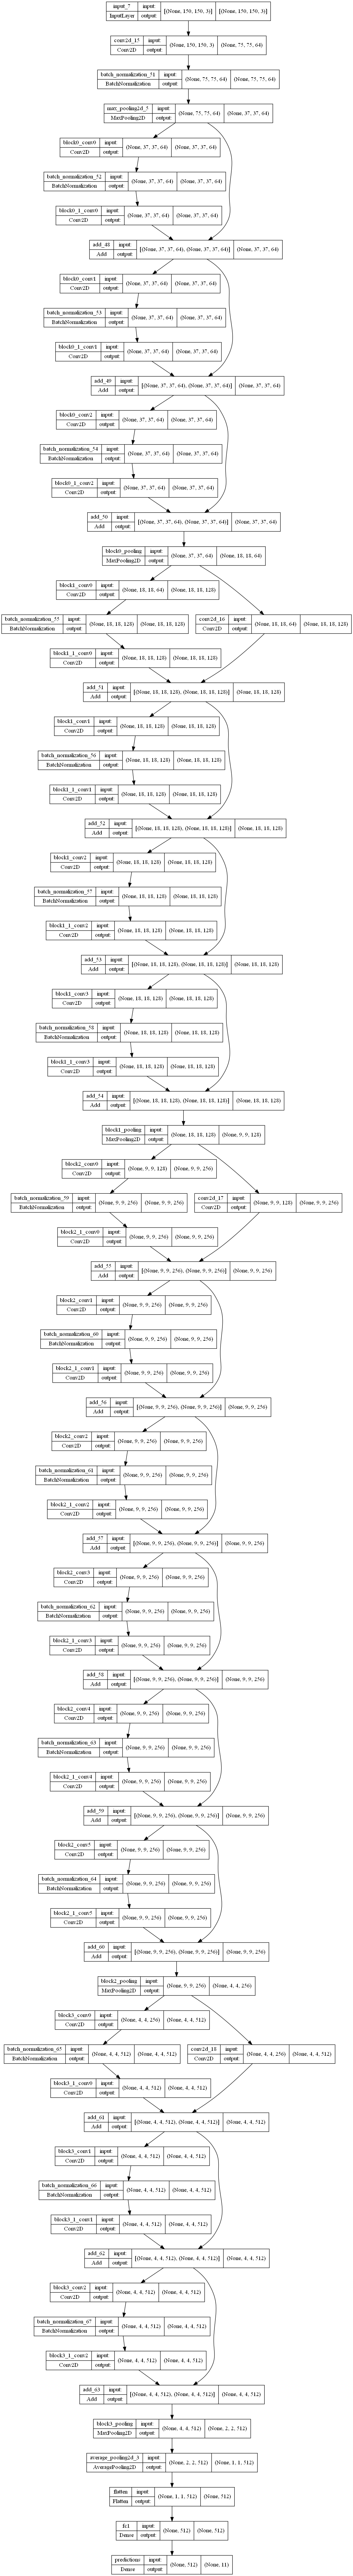

In [39]:
# you can see model summary

tf.keras.utils.plot_model(model, show_shapes=True)

Compiling the Model

In [82]:
from bpmll import bp_mll_loss
import tensorflow as tf
from sklearn.metrics import log_loss, f1_score # not in use right now

# 성능 기반 스케줄링
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=3)

optimizer = tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)


model.compile(loss = bp_mll_loss,
              optimizer= 'adagrad',
              metrics=['accuracy']

              )

# model.compile(loss = tf.nn.softmax_cross_entropy_with_logits,
#               optimizer= optimizer,
#               metrics=['CategoricalCrossentropy', 'accuracy'])

In [83]:
import sklearn

img_arr_s = sklearn.utils.shuffle(img_arr, random_state=123)
y_out_s = sklearn.utils.shuffle(y_out, random_state=123)

weigh = np.array([1/42, 1/89, 1/112, 1/370, 1/135, 1/250, 1/47, 1/347, 1/51, 1/230, 1/50])
weigh = weigh * 1205 / 11
cw = {0:weigh[0], 1:weigh[1], 2:weigh[2], 3:weigh[3], 4:weigh[4], 5:weigh[5], 6:weigh[6], 7:weigh[7], 8:weigh[8], 9:weigh[9], 10:weigh[10]}

In [84]:
with tf.device("/device:GPU:0"):
  history = model.fit(
  x=img_arr_s,
  y=y_out_s,
  validation_split=0.2,
  epochs=40,
  callbacks=[lr_scheduler],
  class_weight = cw,
  batch_size=32
)

Epoch 1/40
31/31 [==============================] - 5s 91ms/step - loss: 0.6704 - accuracy: 0.0654 - val_loss: 0.8932 - val_accuracy: 0.2490 - lr: 0.0010
Epoch 2/40
31/31 [==============================] - 2s 80ms/step - loss: 0.6413 - accuracy: 0.1110 - val_loss: 0.8980 - val_accuracy: 0.1660 - lr: 0.0010
Epoch 3/40
31/31 [==============================] - 3s 84ms/step - loss: 0.6338 - accuracy: 0.1307 - val_loss: 0.9175 - val_accuracy: 0.1660 - lr: 0.0010
Epoch 4/40
31/31 [==============================] - 3s 83ms/step - loss: 0.6347 - accuracy: 0.1442 - val_loss: 0.9018 - val_accuracy: 0.1660 - lr: 0.0010
Epoch 5/40
31/31 [==============================] - 2s 77ms/step - loss: 0.6255 - accuracy: 0.1649 - val_loss: 0.9045 - val_accuracy: 0.1660 - lr: 5.0000e-04
Epoch 6/40
31/31 [==============================] - 2s 76ms/step - loss: 0.6181 - accuracy: 0.1701 - val_loss: 0.9077 - val_accuracy: 0.1660 - lr: 5.0000e-04
Epoch 7/40
31/31 [==============================] - 2s 76ms/step - l

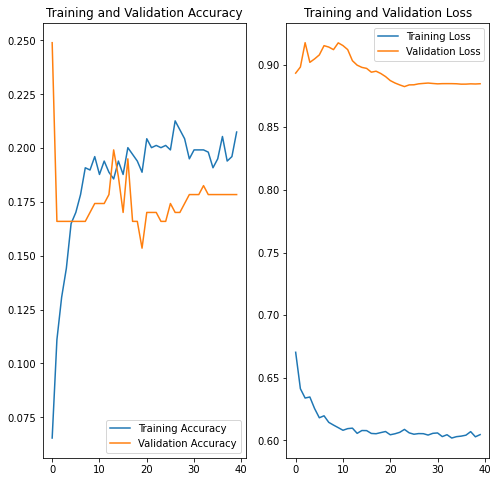

In [85]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(40)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [86]:
k = model.predict(img_arr_s[360:363])

In [87]:
np.set_printoptions(formatter={'float_kind': lambda x: "{0:0.4f}".format(x)})



In [88]:
k

array([[0.0008, 0.3590, 0.9987, 0.9996, 0.8802, 0.9920, 0.9997, 0.9972,
        0.2804, 0.9964, 0.3280],
       [0.0010, 0.3550, 0.9897, 0.9999, 0.4297, 0.9934, 0.9995, 0.9988,
        0.3638, 0.9685, 0.1349],
       [0.0001, 0.0576, 1.0000, 1.0000, 0.9354, 1.0000, 1.0000, 0.9995,
        0.1777, 1.0000, 0.0601]], dtype=float32)

In [89]:
y_out_s[360:363]

array([[0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000,
        0.0000, 0.0000, 0.0000],
       [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 1.0000,
        0.0000, 1.0000, 0.0000],
       [0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000]])

In [178]:
for genre in y_data.columns:
    print(genre, ': ', len(y_data[y_data[genre] == 1]))

Blues :  42
Electronic :  89
Folk, World, & Country :  112
Funk&Soul :  370
Hip Hop :  135
Jazz :  250
Latin :  47
Pop :  347
Reggae :  51
Rock :  230
Stage & Screen :  50
